# Calibration

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from itertools import product as itproduct

In [3]:
from neuroprobnum.utils import math_utils
from neuroprobnum.utils import plot_utils as pltu

# Model

In [4]:
from neuroprobnum.models.hodgkin_huxley import compile_cython
compile_cython()

running build_ext



In [5]:
from neuroprobnum.models.hodgkin_huxley import HHNeuron

neuron = HHNeuron()
neuron

HH_neuron

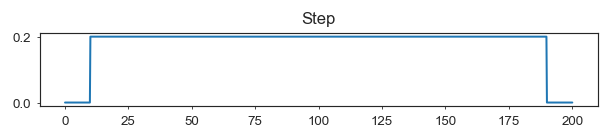

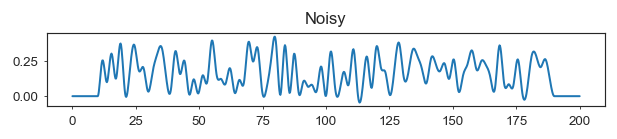

In [6]:
from neuroprobnum.utils import stim_utils

t0, tmax = 0, 200
stim_onset, stim_offset = 10, tmax-10
stims = [
    stim_utils.IStimStep(Iamp=0.2, onset=stim_onset, offset=stim_offset, name='Step'),
    stim_utils.IStimNoisy(Iamp=0.2, onset=stim_onset, offset=stim_offset, name='Noisy', nknots=101, seed=46),

]
for stim in stims: stim.plot(t0=t0, tmax=tmax)

# Data

## Generator

In [7]:
from neuroprobnum.generator.generator_hh import DataGeneratorHH
from copy import deepcopy

gens = {}

for stim in stims:
    
    neuron = deepcopy(neuron)
    neuron.get_Istim_at_t = stim.get_I_at_t
    
    gens[stim] = DataGeneratorHH(
        y0=neuron.compute_yinf(-65), t0=t0, tmax=tmax,
        t_eval_adaptive=math_utils.t_arange(t0, tmax, 1),
        dt_min_eval_fixed=0.1,
        model=neuron, n_samples=100, n_parallel=20,
        gen_det_sols=True, gen_acc_sols=True, acc_same_ts=True,
        base_folder='data',
    )
    gens[stim].update_subfoldername(stim=stim.name)
    gens[stim].load_acc_sols_from_file()    

## Generate data

In [8]:
def get_pert_params(explb, expub, expstep):
    """Get pert params for given exponents"""
    pert_params = 2.** np.append(np.arange(explb, expub, float(expstep)), expub)
    return pert_params


# pert_method, adaptive, methods, step_params, pert_params
solver_params = [   
     # Abdulle, lognormal
    ('abdulle_ln', 0, ['EE'], [0.1, 0.025], get_pert_params(-4, 4, 1)),
    ('abdulle_ln', 0, ['FE'], [0.05, 0.01], get_pert_params(-4, 4, 1)),
    # Conrad
    ('conrad', 0, ['RKBS', 'RKDP'], [0.05, 0.01], get_pert_params(-4, 4, 1)),
    ('conrad', 1, ['RKBS', 'RKDP'], [1e-2, 1e-4], get_pert_params(-4, 4, 1)),
 ]

In [9]:
solver_params[0][-1]

array([ 0.0625,  0.125 ,  0.25  ,  0.5   ,  1.    ,  2.    ,  4.    ,
        8.    , 16.    ])

In [10]:
for stim, gen in gens.items():

    print('----------------------------------------------------------')
    print(stim, ':', gen.subfoldername)
    print('----------------------------------------------------------') 
    
    for pert_method, adaptive, methods, step_params, pert_params in solver_params:
        for step_param, method, pert_param in itproduct(step_params, methods, pert_params):
            gen.gen_and_save_data(
                method=method, adaptive=adaptive, step_param=step_param,
                pert_method=pert_method, pert_param=pert_param,
                overwrite=False, allowgenerror=True,
            )

----------------------------------------------------------
IStimStep(0.2,t=[10,190]) : stim_Step_tmax_200
----------------------------------------------------------
                            EE_f(0.1)_abdulle_ln(0.0625).pkl --> Data already exists.
                             EE_f(0.1)_abdulle_ln(0.125).pkl --> Data already exists.
                              EE_f(0.1)_abdulle_ln(0.25).pkl --> Data already exists.
                               EE_f(0.1)_abdulle_ln(0.5).pkl --> Data already exists.
                                 EE_f(0.1)_abdulle_ln(1).pkl --> Data already exists.
                                 EE_f(0.1)_abdulle_ln(2).pkl --> Data already exists.
                                 EE_f(0.1)_abdulle_ln(4).pkl --> Data already exists.
                                 EE_f(0.1)_abdulle_ln(8).pkl --> Data already exists.
                                EE_f(0.1)_abdulle_ln(16).pkl --> Data already exists.
                          EE_f(0.025)_abdulle_ln(0.0625).pkl 

/gpfs01/berens/user/joesterle/berens/project_probnum/public/neuroprobnum/neuroprobnum/solver/ode_solver.py:800: RuntimeWarning: invalid value encountered in add
  y_new = y + step_h * np.dot(self.K[:self.B.size, :].T, self.B)
/gpfs01/berens/user/joesterle/berens/project_probnum/public/neuroprobnum/neuroprobnum/solver/ode_solver.py:800: RuntimeWarning: invalid value encountered in add
  y_new = y + step_h * np.dot(self.K[:self.B.size, :].T, self.B)
/gpfs01/berens/user/joesterle/berens/project_probnum/public/neuroprobnum/neuroprobnum/solver/ode_solver.py:800: RuntimeWarning: invalid value encountered in add
  y_new = y + step_h * np.dot(self.K[:self.B.size, :].T, self.B)
/gpfs01/berens/user/joesterle/berens/project_probnum/public/neuroprobnum/neuroprobnum/solver/ode_solver.py:800: RuntimeWarning: invalid value encountered in add
  y_new = y + step_h * np.dot(self.K[:self.B.size, :].T, self.B)
/gpfs01/berens/user/joesterle/berens/project_probnum/public/neuroprobnum/neuroprobnum/solver/ode

Data generation failed
                                FE_f(0.05)_abdulle_ln(8).pkl --> Generate data because Data is None.


/gpfs01/berens/user/joesterle/berens/project_probnum/public/neuroprobnum/neuroprobnum/solver/ode_solver.py:800: RuntimeWarning: invalid value encountered in add
  y_new = y + step_h * np.dot(self.K[:self.B.size, :].T, self.B)
/gpfs01/berens/user/joesterle/berens/project_probnum/public/neuroprobnum/neuroprobnum/solver/ode_solver.py:800: RuntimeWarning: invalid value encountered in add
  y_new = y + step_h * np.dot(self.K[:self.B.size, :].T, self.B)
/gpfs01/berens/user/joesterle/berens/project_probnum/public/neuroprobnum/neuroprobnum/solver/ode_solver.py:800: RuntimeWarning: invalid value encountered in add
  y_new = y + step_h * np.dot(self.K[:self.B.size, :].T, self.B)
/gpfs01/berens/user/joesterle/berens/project_probnum/public/neuroprobnum/neuroprobnum/solver/ode_solver.py:800: RuntimeWarning: invalid value encountered in add
  y_new = y + step_h * np.dot(self.K[:self.B.size, :].T, self.B)
/gpfs01/berens/user/joesterle/berens/project_probnum/public/neuroprobnum/neuroprobnum/solver/ode

Data generation failed
                               FE_f(0.05)_abdulle_ln(16).pkl --> Generate data because Data is None.


/gpfs01/berens/user/joesterle/berens/project_probnum/public/neuroprobnum/neuroprobnum/solver/ode_solver.py:800: RuntimeWarning: invalid value encountered in add
  y_new = y + step_h * np.dot(self.K[:self.B.size, :].T, self.B)
/gpfs01/berens/user/joesterle/berens/project_probnum/public/neuroprobnum/neuroprobnum/solver/ode_solver.py:800: RuntimeWarning: invalid value encountered in add
  y_new = y + step_h * np.dot(self.K[:self.B.size, :].T, self.B)
/gpfs01/berens/user/joesterle/berens/project_probnum/public/neuroprobnum/neuroprobnum/solver/ode_solver.py:800: RuntimeWarning: invalid value encountered in add
  y_new = y + step_h * np.dot(self.K[:self.B.size, :].T, self.B)
/gpfs01/berens/user/joesterle/berens/project_probnum/public/neuroprobnum/neuroprobnum/solver/ode_solver.py:800: RuntimeWarning: invalid value encountered in add
  y_new = y + step_h * np.dot(self.K[:self.B.size, :].T, self.B)
/gpfs01/berens/user/joesterle/berens/project_probnum/public/neuroprobnum/neuroprobnum/solver/ode

Data generation failed
                           FE_f(0.01)_abdulle_ln(0.0625).pkl --> Data already exists.
                            FE_f(0.01)_abdulle_ln(0.125).pkl --> Data already exists.
                             FE_f(0.01)_abdulle_ln(0.25).pkl --> Data already exists.
                              FE_f(0.01)_abdulle_ln(0.5).pkl --> Data already exists.
                                FE_f(0.01)_abdulle_ln(1).pkl --> Data already exists.
                                FE_f(0.01)_abdulle_ln(2).pkl --> Data already exists.
                                FE_f(0.01)_abdulle_ln(4).pkl --> Data already exists.
                                FE_f(0.01)_abdulle_ln(8).pkl --> Data already exists.
                               FE_f(0.01)_abdulle_ln(16).pkl --> Data already exists.
                             RKBS_f(0.05)_conrad(0.0625).pkl --> Data already exists.
                              RKBS_f(0.05)_conrad(0.125).pkl --> Data already exists.
                               

/gpfs01/berens/user/joesterle/berens/project_probnum/public/neuroprobnum/neuroprobnum/solver/ode_solver.py:461: RuntimeWarning: invalid value encountered in add
  self.y_new += self.perturbation


Data generation failed
                             RKDP_f(0.05)_conrad(0.0625).pkl --> Data already exists.
                              RKDP_f(0.05)_conrad(0.125).pkl --> Data already exists.
                               RKDP_f(0.05)_conrad(0.25).pkl --> Data already exists.
                                RKDP_f(0.05)_conrad(0.5).pkl --> Data already exists.
                                  RKDP_f(0.05)_conrad(1).pkl --> Data already exists.
                                  RKDP_f(0.05)_conrad(2).pkl --> Data already exists.
                                  RKDP_f(0.05)_conrad(4).pkl --> Data already exists.
                                  RKDP_f(0.05)_conrad(8).pkl --> Data already exists.
                                 RKDP_f(0.05)_conrad(16).pkl --> Data already exists.
                             RKBS_f(0.01)_conrad(0.0625).pkl --> Data already exists.
                              RKBS_f(0.01)_conrad(0.125).pkl --> Data already exists.
                               

/gpfs01/berens/user/joesterle/berens/project_probnum/public/neuroprobnum/neuroprobnum/solver/ode_solver.py:800: RuntimeWarning: invalid value encountered in add
  y_new = y + step_h * np.dot(self.K[:self.B.size, :].T, self.B)
/gpfs01/berens/user/joesterle/berens/project_probnum/public/neuroprobnum/neuroprobnum/solver/ode_solver.py:800: RuntimeWarning: invalid value encountered in add
  y_new = y + step_h * np.dot(self.K[:self.B.size, :].T, self.B)
/gpfs01/berens/user/joesterle/berens/project_probnum/public/neuroprobnum/neuroprobnum/solver/ode_solver.py:800: RuntimeWarning: invalid value encountered in add
  y_new = y + step_h * np.dot(self.K[:self.B.size, :].T, self.B)


Data generation failed
                                FE_f(0.05)_abdulle_ln(8).pkl --> Generate data because Data is None.


/gpfs01/berens/user/joesterle/berens/project_probnum/public/neuroprobnum/neuroprobnum/solver/ode_solver.py:800: RuntimeWarning: invalid value encountered in add
  y_new = y + step_h * np.dot(self.K[:self.B.size, :].T, self.B)
/gpfs01/berens/user/joesterle/berens/project_probnum/public/neuroprobnum/neuroprobnum/solver/ode_solver.py:800: RuntimeWarning: invalid value encountered in add
  y_new = y + step_h * np.dot(self.K[:self.B.size, :].T, self.B)
/gpfs01/berens/user/joesterle/berens/project_probnum/public/neuroprobnum/neuroprobnum/solver/ode_solver.py:800: RuntimeWarning: invalid value encountered in add
  y_new = y + step_h * np.dot(self.K[:self.B.size, :].T, self.B)
/gpfs01/berens/user/joesterle/berens/project_probnum/public/neuroprobnum/neuroprobnum/solver/ode_solver.py:800: RuntimeWarning: invalid value encountered in add
  y_new = y + step_h * np.dot(self.K[:self.B.size, :].T, self.B)
/gpfs01/berens/user/joesterle/berens/project_probnum/public/neuroprobnum/neuroprobnum/solver/ode

Data generation failed
                               FE_f(0.05)_abdulle_ln(16).pkl --> Generate data because Data is None.


/gpfs01/berens/user/joesterle/berens/project_probnum/public/neuroprobnum/neuroprobnum/solver/ode_solver.py:800: RuntimeWarning: invalid value encountered in add
  y_new = y + step_h * np.dot(self.K[:self.B.size, :].T, self.B)
/gpfs01/berens/user/joesterle/berens/project_probnum/public/neuroprobnum/neuroprobnum/solver/ode_solver.py:800: RuntimeWarning: invalid value encountered in add
  y_new = y + step_h * np.dot(self.K[:self.B.size, :].T, self.B)
/gpfs01/berens/user/joesterle/berens/project_probnum/public/neuroprobnum/neuroprobnum/solver/ode_solver.py:800: RuntimeWarning: invalid value encountered in add
  y_new = y + step_h * np.dot(self.K[:self.B.size, :].T, self.B)
/gpfs01/berens/user/joesterle/berens/project_probnum/public/neuroprobnum/neuroprobnum/solver/ode_solver.py:800: RuntimeWarning: invalid value encountered in add
  y_new = y + step_h * np.dot(self.K[:self.B.size, :].T, self.B)
/gpfs01/berens/user/joesterle/berens/project_probnum/public/neuroprobnum/neuroprobnum/solver/ode

Data generation failed
                           FE_f(0.01)_abdulle_ln(0.0625).pkl --> Data already exists.
                            FE_f(0.01)_abdulle_ln(0.125).pkl --> Data already exists.
                             FE_f(0.01)_abdulle_ln(0.25).pkl --> Data already exists.
                              FE_f(0.01)_abdulle_ln(0.5).pkl --> Data already exists.
                                FE_f(0.01)_abdulle_ln(1).pkl --> Data already exists.
                                FE_f(0.01)_abdulle_ln(2).pkl --> Data already exists.
                                FE_f(0.01)_abdulle_ln(4).pkl --> Data already exists.
                                FE_f(0.01)_abdulle_ln(8).pkl --> Data already exists.
                               FE_f(0.01)_abdulle_ln(16).pkl --> Generate data because Data is None.
Data generation failed
                             RKBS_f(0.05)_conrad(0.0625).pkl --> Data already exists.
                              RKBS_f(0.05)_conrad(0.125).pkl --> Data already e

/gpfs01/berens/user/joesterle/berens/project_probnum/public/neuroprobnum/neuroprobnum/solver/ode_solver.py:461: RuntimeWarning: invalid value encountered in add
  self.y_new += self.perturbation


Data generation failed
                             RKDP_f(0.05)_conrad(0.0625).pkl --> Data already exists.
                              RKDP_f(0.05)_conrad(0.125).pkl --> Data already exists.
                               RKDP_f(0.05)_conrad(0.25).pkl --> Data already exists.
                                RKDP_f(0.05)_conrad(0.5).pkl --> Data already exists.
                                  RKDP_f(0.05)_conrad(1).pkl --> Data already exists.
                                  RKDP_f(0.05)_conrad(2).pkl --> Data already exists.
                                  RKDP_f(0.05)_conrad(4).pkl --> Data already exists.
                                  RKDP_f(0.05)_conrad(8).pkl --> Data already exists.
                                 RKDP_f(0.05)_conrad(16).pkl --> Data already exists.
                             RKBS_f(0.01)_conrad(0.0625).pkl --> Data already exists.
                              RKBS_f(0.01)_conrad(0.125).pkl --> Data already exists.
                               

## Load data

In [11]:
from neuroprobnum.generator.dataloader import DataLoader

df = pd.DataFrame()
for stim, gen in gens.items():
    stim_df = DataLoader(gen).load_data2dataframe(solver_params, drop_traces=False, allowgenerror=True)   
    stim_df['stimfun'] = stim
    stim_df['stim'] = stim.name
    df = df.append(stim_df, ignore_index=True)

In [12]:
df.head()

,MAE_DR,MAE_SM,MAE_SR,acc_ts,acc_vs,adaptive,det_nODEcalls,det_run_time,det_ts,det_vs,...,pert_param,run_times,seed,step_param,t0,tmax,ts,vs,stimfun,stim
0,22.956636,"[0.41017454913761603, 1.8406671483166064, 0.58...","[22.987664942555806, 22.915590313538118, 22.94...","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[-65.0, -64.99996862359615, -64.99993891373829...",0,2000.0,0.046474,"[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[-65.0, -64.99996870091516, -64.99993945138549...",...,0.0625,"[0.0634927749633789, 0.061342716217041016, 0.0...","[12475674, 1080776788, 1858585705, 1629164900,...",0.1,0.0,200.0,"[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[[-65.0, -64.99996883347261, -64.9999392323195...","IStimStep(0.2,t=[10,190])",Step
1,22.956636,"[0.8564888924780238, 3.6279925038415604, 1.149...","[23.015788439554083, 22.850369325495006, 22.93...","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[-65.0, -64.99996862359615, -64.99993891373829...",0,2000.0,0.044102,"[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[-65.0, -64.99996870091516, -64.99993945138549...",...,0.1250,"[0.07817292213439941, 0.0643012523651123, 0.07...","[12475674, 1080776788, 1858585705, 1629164900,...",0.1,0.0,200.0,"[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[[-65.0, -64.99996897711705, -64.9999390310099...","IStimStep(0.2,t=[10,190])",Step
2,22.956636,"[1.853735111711297, 6.830111881227612, 2.22006...","[23.05596561763939, 22.654186521274145, 22.918...","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[-65.0, -64.99996862359615, -64.99993891373829...",0,2000.0,0.047751,"[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[-65.0, -64.99996870091516, -64.99993945138549...",...,0.2500,"[0.09650111198425293, 0.07912111282348633, 0.0...","[12475674, 1080776788, 1858585705, 1629164900,...",0.1,0.0,200.0,"[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[[-65.0, -64.999969296564, -64.999938682555, -...","IStimStep(0.2,t=[10,190])",Step
3,22.956636,"[4.041589757280124, 11.931043563967847, 4.0955...","[23.02890225717981, 22.066100531682437, 22.886...","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[-65.0, -64.99996862359615, -64.99993891373829...",0,2000.0,0.044717,"[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[-65.0, -64.99996870091516, -64.99993945138549...",...,0.5000,"[0.0924081802368164, 0.07878923416137695, 0.07...","[12475674, 1080776788, 1858585705, 1629164900,...",0.1,0.0,200.0,"[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[[-65.0, -64.99997005453906, -64.9999382053450...","IStimStep(0.2,t=[10,190])",Step
4,22.956636,"[7.5498758239682235, 17.683847423136616, 7.000...","[22.23470939266428, 20.181756753885946, 22.855...","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[-65.0, -64.99996862359615, -64.99993891373829...",0,2000.0,0.044162,"[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[-65.0, -64.99996870091516, -64.99993945138549...",...,1.0000,"[0.07056093215942383, 0.06995940208435059, 0.0...","[12475674, 1080776788, 1858585705, 1629164900,...",0.1,0.0,200.0,"[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[[-65.0, -64.99997195034447, -64.9999381076709...","IStimStep(0.2,t=[10,190])",Step


In [13]:
import utils

utils.add_SR_SM(df)
df.head()

,MAE_DR,MAE_SM,MAE_SR,acc_ts,acc_vs,adaptive,det_nODEcalls,det_run_time,det_ts,det_vs,...,ts,vs,stimfun,stim,MAE_SR_avg,MAE_SM_avg,MAER_SM_SR,MAER_DR_SR,MAERP_SM_DR,MAERP_SM_DR_c
0,22.956636,"[0.41017454913761603, 1.8406671483166064, 0.58...","[22.987664942555806, 22.915590313538118, 22.94...","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[-65.0, -64.99996862359615, -64.99993891373829...",0,2000.0,0.046474,"[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[-65.0, -64.99996870091516, -64.99993945138549...",...,"[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[[-65.0, -64.99996883347261, -64.9999392323195...","IStimStep(0.2,t=[10,190])",Step,22.953145,0.602171,0.026235,1.000152,0.026239,0.026235
1,22.956636,"[0.8564888924780238, 3.6279925038415604, 1.149...","[23.015788439554083, 22.850369325495006, 22.93...","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[-65.0, -64.99996862359615, -64.99993891373829...",0,2000.0,0.044102,"[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[-65.0, -64.99996870091516, -64.99993945138549...",...,"[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[[-65.0, -64.99996897711705, -64.9999390310099...","IStimStep(0.2,t=[10,190])",Step,22.943740,1.206784,0.052598,1.000562,0.052627,0.052598
2,22.956636,"[1.853735111711297, 6.830111881227612, 2.22006...","[23.05596561763939, 22.654186521274145, 22.918...","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[-65.0, -64.99996862359615, -64.99993891373829...",0,2000.0,0.047751,"[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[-65.0, -64.99996870091516, -64.99993945138549...",...,"[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[[-65.0, -64.999969296564, -64.999938682555, -...","IStimStep(0.2,t=[10,190])",Step,22.904769,2.394717,0.104551,1.002264,0.104788,0.104551
3,22.956636,"[4.041589757280124, 11.931043563967847, 4.0955...","[23.02890225717981, 22.066100531682437, 22.886...","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[-65.0, -64.99996862359615, -64.99993891373829...",0,2000.0,0.044717,"[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[-65.0, -64.99996870091516, -64.99993945138549...",...,"[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[[-65.0, -64.99997005453906, -64.9999382053450...","IStimStep(0.2,t=[10,190])",Step,22.727308,4.555582,0.200445,1.010090,0.202468,0.200445
4,22.956636,"[7.5498758239682235, 17.683847423136616, 7.000...","[22.23470939266428, 20.181756753885946, 22.855...","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[-65.0, -64.99996862359615, -64.99993891373829...",0,2000.0,0.044162,"[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[-65.0, -64.99996870091516, -64.99993945138549...",...,"[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[[-65.0, -64.99997195034447, -64.9999381076709...","IStimStep(0.2,t=[10,190])",Step,22.018006,7.923037,0.359844,1.042630,0.375184,0.359844


# Plot

## Plot functions

In [14]:
def stim2kwargs(stim):
    if stim == 'Step':
        return dict(color='gray', marker='.', ls='-', label='Step', lw=0.8, alpha=0.9, markersize=3)
    elif stim == 'Noisy':
        return dict(color='black', marker='.', ls='-', label='Noisy', lw=0.8, alpha=0.9, markersize=3)
    else:
        raise NotImplementedError()

In [15]:
def plot_R(ax, data_rows, x='N', plot_kw=dict(marker='.', ls = '-', c='k'), ylim=1.3, clipat=1.2, logfun=np.log2):
    """Plot MAE ratio for data rows."""

    ydata = data_rows[x]
    ylabel = pltu.metric2label(x)

    # Plot data
    ax.plot(logfun(data_rows.pert_param), np.minimum(ydata, clipat), clip_on=False, **plot_kw)
    
    # Highlight larger values
    if np.any(ydata > clipat):
        ax.plot(logfun(data_rows.pert_param)[ydata>clipat], np.minimum(ydata[ydata>clipat], clipat)[ydata>clipat],
                clip_on=True, color='darkred', marker='o', fillstyle='none', alpha=0.6, ls='none')

    ax.set_ylabel(pltu.text2mathtext(ylabel))
    if logfun == np.log10:
        ax.set_xlabel(pltu.text2mathtext("log_10 " + f"({pltu.pert_param_symbol})"))
    elif logfun == np.log2:
        ax.set_xlabel(pltu.text2mathtext("log_2 " + f"({pltu.pert_param_symbol})"))
    else:
        ax.set_xlabel(str(logfun))

    #ax.spines['left'].set_bounds([0, 1])
    ax.set(ylim=[-0.05, ylim], yticks=[0, 1])

In [16]:
def plot_MAE_hists_sharedx(axs, data_rows, x1='SM', x2='SR', xline='DR'):
    """Plot MAE histograms of SS and SR, also plot DR"""
    
    assert len(axs) == len(data_rows)
    
    ymin = np.inf
    ymax = np.NINF
    
    for _, data_row in data_rows.iterrows():
        if data_row.n_samples > 0:
            ymin_i = np.min([np.min(data_row[f'MAE_{x1}']), np.min(data_row[f'MAE_{x2}']), data_row[f'MAE_{xline}']])
            ymax_i = np.max([np.max(data_row[f'MAE_{x1}']), np.max(data_row[f'MAE_{x2}']), data_row[f'MAE_{xline}']])
            
            if ymin_i < ymin:
                ymin = ymin_i
            if ymax_i > ymax:
                ymax = ymax_i
                
    for ax, (_, data_row) in zip(axs, data_rows.iterrows()):
        plot_MAE_hist(ax, data_row, ymin, ymax, x1=x1, x2=x2, xline=xline)
        

def plot_MAE_hist(ax, data_row, ymin, ymax, x1='SM', x2='SR', xline='DR'):
    """Plot MAE histograms of SS and SR, also plot DR"""
    
    if data_row.n_samples == 0: return
            
    # Plot
    for i, (x, color) in enumerate(zip([x1, x2], ['red', 'C0'])):
        
        sns.histplot(
            data_row[f'MAE_{x}'], ax=ax, label=x, color=color, bins=np.linspace(ymin, ymax, 15, endpoint=True),
            stat="probability", element="step", fill=True, alpha=0.2
        )
        ax.plot(np.mean(data_row[f'MAE_{x}']), 0, color=color, ls='-', marker='v', clip_on=False, alpha=0.6)

    ax.axvline(data_row[f'MAE_{xline}'], color='grey', label='DR', ls='--', zorder=1000)
    ax.set(xlabel='MAE', ylabel='Norm. count', title=pltu.text2mathtext(f"{pltu.pert_param_symbol}={data_row.pert_param:.2f}"))

## Histograms and Sigmoid

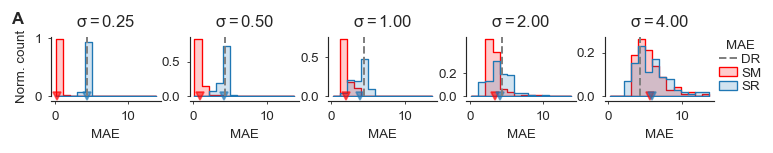

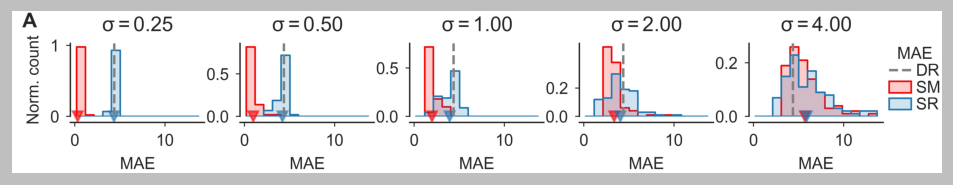

In [17]:
data_rows_ex = df[(df.method=='EE') & (df.adaptive==0) & (df.step_param==0.025) & (df.pert_method=='abdulle_ln') & (df.stim=='Noisy')]
data_rows_hist = data_rows_ex[(data_rows_ex.pert_param >= 0.25) & (data_rows_ex.pert_param <= 4)]

assert data_rows_hist.size > 0

fig, axs = pltu.subplots(len(data_rows_hist), 1, yoffsize=0.2, ysizerow=0.9)
sns.despine()
pltu.set_labs(axs[0], panel_nums='auto', panel_num_space=6)

plot_MAE_hists_sharedx(axs, data_rows=data_rows_hist, x1='SM', x2='SR', xline='DR')

for ax in axs[1:].flat:
    ax.set(ylabel=None)
    
pltu.move_xaxis_outward(axs, scale=3)
axs[-1].legend(loc='center left', frameon=False, bbox_to_anchor=(1.02, 0.5), handlelength=1.35, title='MAE')
axs[2].set_yticks([0, 0.5])
axs[3].set_yticks([0, 0.2])
    
plt.tight_layout(pad=0.1, w_pad=0.1)

pltu.savefig("fig6a")
plt.show()
pltu.show_saved_figure(fig)

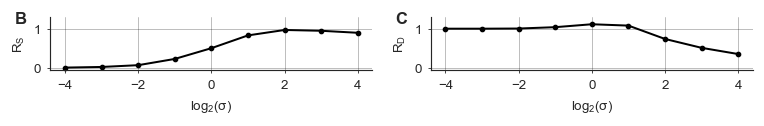

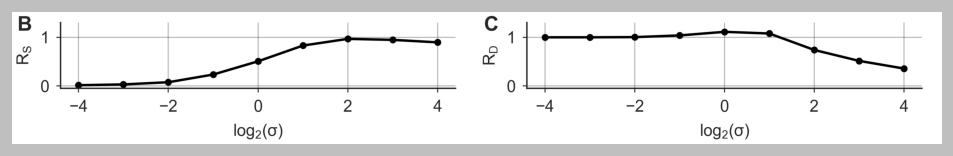

In [18]:
assert data_rows_ex.size > 0

R_modes = ['MAER_SM_SR', 'MAER_DR_SR']

for R_mode in R_modes:
    assert R_mode in data_rows_ex, R_mode

fig, axs = pltu.subplots(len(R_modes), 1, ysizerow=0.9)
sns.despine()
pltu.set_labs(axs, panel_nums=['B', 'C', 'D'], panel_num_space=5, panel_num_va='top', panel_num_y=1.1)

for ax, R_mode in zip(axs, R_modes):
    plot_R(ax=ax, data_rows=data_rows_ex, x=R_mode)
    
pltu.grid(ax=axs)
    
pltu.make_share_ylims(axs)
plt.tight_layout(pad=0.1, w_pad=1.5, rect=[0, 0, 0.98, 1])
    
pltu.savefig("fig6b_c")
plt.show()
pltu.show_saved_figure(fig)

### Text

In [19]:
data_rows_ex[data_rows_ex.pert_param==0.25][['pert_param', 'MAE_SM_avg', 'MAE_DR', 'MAE_SR_avg']].iloc[0]

pert_param    0.250000
MAE_SM_avg    0.331107
MAE_DR        4.363293
MAE_SR_avg    4.347804
Name: 119, dtype: float64

In [20]:
for k, v in data_rows_ex[data_rows_ex.pert_param==0.25][['pert_param', 'MAE_SM_avg', 'MAE_DR', 'MAE_SR_avg']].iloc[0].items():
    print(k.ljust(15), f"{v:.2f}")

pert_param      0.25
MAE_SM_avg      0.33
MAE_DR          4.36
MAE_SR_avg      4.35


In [21]:
print(f"{np.percentile(data_rows_ex[data_rows_ex.pert_param==0.25]['MAE_SR'].iloc[0], q=10):.2f}")
print(f"{np.percentile(data_rows_ex[data_rows_ex.pert_param==0.25]['MAE_SR'].iloc[0], q=90):.2f}")

4.14
4.56


In [22]:
for i, row in data_rows_ex.iterrows():
    print(f"{row.pert_param}".ljust(8), f"R_DR_SR = {row.MAER_DR_SR:.2f},   R_SM_SR = {row.MAER_SM_SR:.2f}")

0.0625   R_DR_SR = 1.00,   R_SM_SR = 0.02
0.125    R_DR_SR = 1.00,   R_SM_SR = 0.03
0.25     R_DR_SR = 1.00,   R_SM_SR = 0.08
0.5      R_DR_SR = 1.04,   R_SM_SR = 0.23
1.0      R_DR_SR = 1.11,   R_SM_SR = 0.51
2.0      R_DR_SR = 1.08,   R_SM_SR = 0.83
4.0      R_DR_SR = 0.74,   R_SM_SR = 0.97
8.0      R_DR_SR = 0.51,   R_SM_SR = 0.95
16.0     R_DR_SR = 0.36,   R_SM_SR = 0.90


In [23]:
data_rows_ex[['pert_param', 'MAER_SM_SR']]

,pert_param,MAER_SM_SR
117,0.0625,0.015093
118,0.1250,0.031230
119,0.2500,0.076155
120,0.5000,0.234235
121,1.0000,0.506362
122,2.0000,0.829845
123,4.0000,0.967173
124,8.0000,0.946936
125,16.0000,0.895687


## All methods

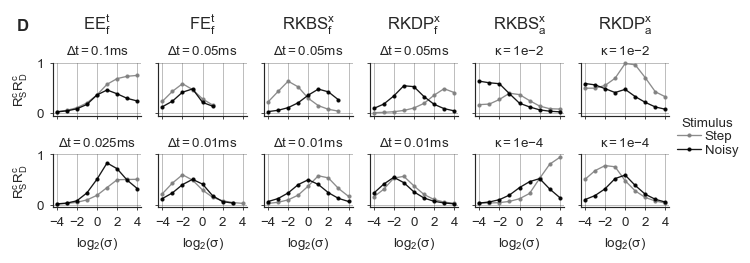

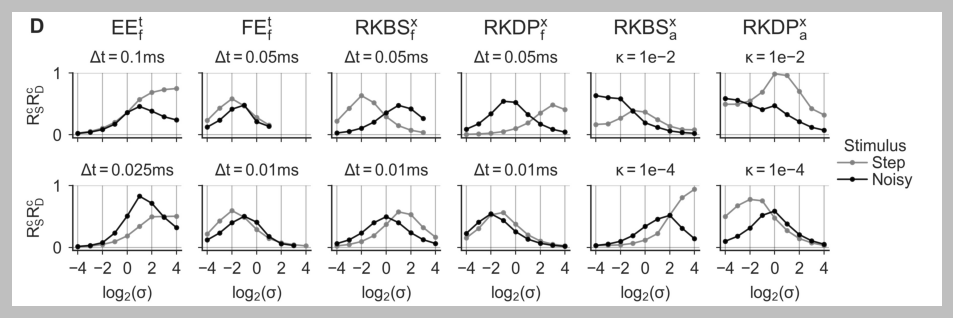

In [24]:
df_methods = df.groupby(by=['method', 'pert_method', 'adaptive'], sort=False)

n_rows = 2
n_cols = len(df_methods)

fig, axs = pltu.subplots(n_cols, n_rows, xsize='fullwidth', yoffsize=0.4, ysizerow=0.8, squeeze=False, sharex='all', sharey='all')
sns.despine()
pltu.set_labs(axs[0, 0], panel_nums=['D'], panel_num_space=5, panel_num_va='bottom', panel_num_y=1.4)

for ax_col, ((method, pert_method, adaptive), df_method) in zip(axs.T , df_methods):   
    df_method_is = df_method.groupby(["step_param"], sort=False)
    for ax, (step_param, df_method_i) in zip(ax_col, df_method_is):
        ax.set_title(pltu.step_param2label(step_param=step_param, adaptive=adaptive), fontsize=plt.rcParams['font.size'], pad=5)
        
        for stim, data_rows in df_method_i.groupby(by=["stim"], sort=False):
            plot_R(ax=ax, data_rows=data_rows, x='MAERP_SM_DR_c', plot_kw=stim2kwargs(stim), ylim=1.0, clipat=np.inf)
            
    for ax in ax_col[:len(df_method_is)-1]:
        ax.set_xlabel(None)
    
for ax in axs[:, 1:].flat:
    ax.set(ylabel=None)
    
for ax in axs.flat:
    ax.set_xticks([-4, -2, 0, 2, 4])
    
pltu.grid(ax=axs)
    
plt.tight_layout(w_pad=1, pad=0.1, h_pad=1.2, rect=[0.01, 0, 0.88, 1.03])

for ax_col, ((method, pert_method, adaptive), _) in zip(axs.T , df_methods):
    ax = ax_col[0]
    ax.text(
        0.5, 1.5, pltu.method2label(method=method, pert_method=pert_method, adaptive=adaptive),
        transform=ax.transAxes, va='bottom', ha='center', fontsize=plt.rcParams['axes.titlesize'], clip_on=False)
    
axs[0, -1].legend(loc='center left', bbox_to_anchor=(1.05, -0.4), title='Stimulus')

pltu.savefig("fig6d")
plt.show()
pltu.show_saved_figure(fig)

## Appendix figure

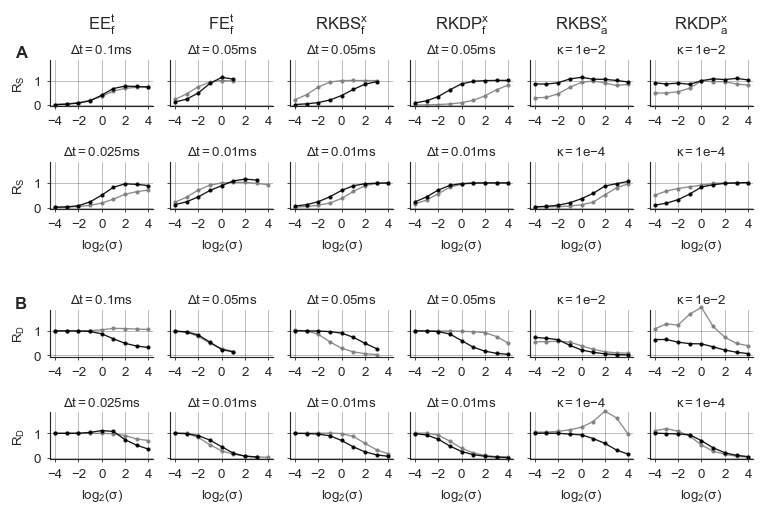

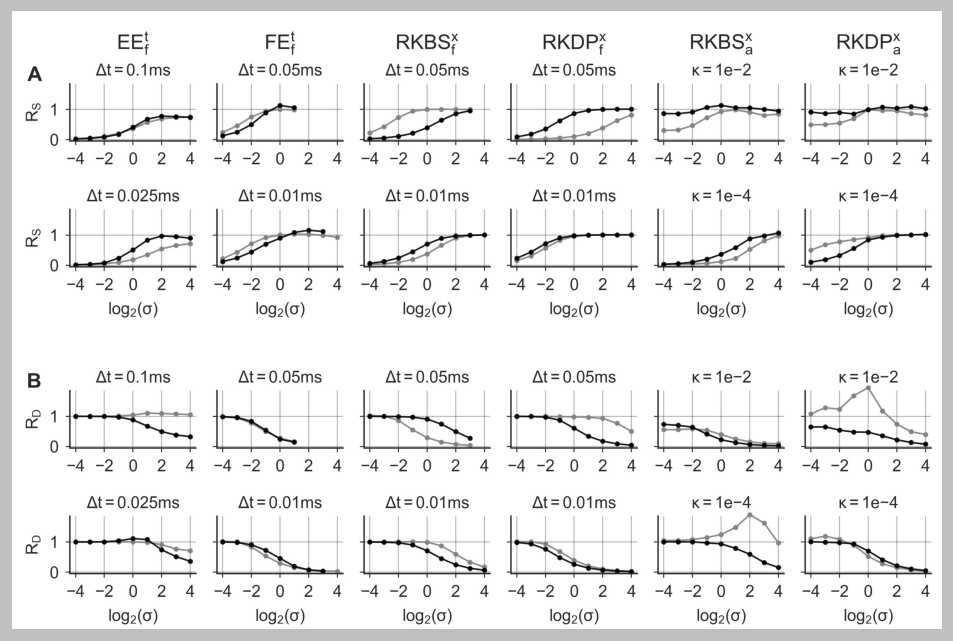

In [25]:
df_methods = df.groupby(by=['method', 'pert_method', 'adaptive'], sort=False)

n_rows = 4
n_cols = len(df_methods)

fig, all_axs = pltu.subplots(n_cols, n_rows, xsize='fullwidth', yoffsize=0.6, ysizerow=0.9, squeeze=False, sharex='row', sharey='all')
sns.despine()
pltu.set_labs(all_axs[[0, 2], 0], panel_nums='auto', panel_num_space=5, panel_num_va='center', panel_num_y=1.0)

for axs, metric in zip([all_axs[:2,:], all_axs[2:,:]], ['MAER_SM_SR', 'MAER_DR_SR']):
    for ax_col, ((method, pert_method, adaptive), df_method) in zip(axs.T , df_methods):   
        df_method_is = df_method.groupby(["step_param"], sort=False)
        for ax, (step_param, df_method_i) in zip(ax_col, df_method_is):
            ax.set_title(pltu.step_param2label(step_param=step_param, adaptive=adaptive), fontsize=plt.rcParams['font.size'], pad=4)

            for stim, data_rows in df_method_i.groupby(by=["stim"], sort=False):
                plot_R(ax=ax, data_rows=data_rows, x=metric, plot_kw=stim2kwargs(stim), ylim=1.85, clipat=np.inf)
            
for axs in [all_axs[:2,:], all_axs[2:,:]]:
    
    for ax_col, ((method, pert_method, adaptive), df_method) in zip(axs.T , df_methods):   
        for ax in ax_col[:len(df_method_is)-1]:
            ax.set_xlabel(None)
        for ax in ax_col[len(df_method_is):]:
            ax.axis('off')
            
    for ax in axs[:, 1:].flat:
        ax.set(ylabel=None)
    
pltu.grid(ax=all_axs)
    
for ax in all_axs.flat:
    ax.set_xticks([-4, -2, 0, 2, 4])
    
plt.tight_layout(w_pad=1, pad=0.1, h_pad=0.7, rect=[0.01, 0, 0.99, 0.92])

for ax_col, ((method, pert_method, adaptive), _) in zip(all_axs.T , df_methods):
    ax = ax_col[0]
    ax.text(
        0.5, 1.5, pltu.method2label(method=method, pert_method=pert_method, adaptive=adaptive),
        transform=ax.transAxes, va='bottom', ha='center', fontsize=plt.rcParams['axes.titlesize'], clip_on=False)

pltu.move_box(all_axs[1, :], dy=+0.03)
pltu.move_box(all_axs[2, :], dy=-0.03)

pltu.savefig("figS3")
plt.show()
pltu.show_saved_figure(fig)